In [8]:
import os
from glob import glob
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np

In [7]:
data_path = "/userhome/student/bial/neural-punctuator/models/"
model_names = ["bert-base-uncased", "bert-base-cased", "albert-base-v1"]

In [9]:
files = {}
for model_name in model_names:
    f = sorted(glob(data_path + f"{model_name}-epoch*.*"), key=os.path.getmtime)
    files[model_name] = f

In [10]:
def load_scores(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint['metrics']

def get_strict_f_score(report):
    return sum(float(report['cls_report'][output]['f1-score']) for output in ('period', 'question', 'comma')) / 3
    
# metrics = {}
# for model_name in model_names:
#     m = []
#     for file in tqdm(files[model_name]):
#         m.append(load_scores(file))
#     metrics[model_name] = m
    
# with open('reports/metrics.pkl', 'wb') as f:
#     pickle.dump(metrics, f)
    
with open('reports/metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)
    
for _, m in metrics.items():
    for epoch in m:
        epoch['strict_f_score'] = get_strict_f_score(epoch)
        
def best_epoch_by_f_score(metrics):
    best_score = metrics[0]['strict_f_score']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['strict_f_score'] > best_score:
            best_score = m['strict_f_score']
            best_epoch = i
    return best_epoch, best_score

def best_epoch_by_loss(metrics):
    best_loss = metrics[0]['loss']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['loss'] < best_loss:
            best_loss = m['loss']
            best_epoch = i
    return best_epoch, best_loss

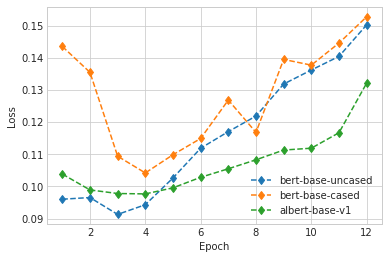

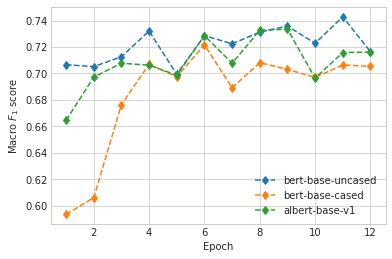

In [17]:
plt.style.use('seaborn-whitegrid')
# plt.title('Valid loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    loss = [float(epoch['loss']) for epoch in m ]
    plt.plot(np.arange(len(loss))+1, loss, '--d')
plt.legend(model_names)
plt.savefig('imgs/valid_loss.pdf')
plt.show()

plt.style.use('seaborn-whitegrid')
# plt.title('Valid F1-score')
plt.ylabel('Macro $F_1$ score')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    f_score = [float(epoch['strict_f_score']) for epoch in m ]
    plt.plot(np.arange(len(loss))+1, f_score, '--d')
plt.legend(model_names)
plt.savefig('imgs/valid_f1_score.pdf')
plt.show()

In [12]:
from neural_punctuator.utils.data import get_config_from_yaml
from neural_punctuator.models.BertPunctuator import BertPunctuator

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from neural_punctuator.data.dataloader import BertDataset, collate, get_data_loaders, get_datasets
from neural_punctuator.models.BertPunctuator import BertPunctuator
from torch.optim import AdamW
from torch import nn

from neural_punctuator.utils.io import save, load
from neural_punctuator.utils.metrics import get_total_grad_norm, get_eval_metrics
import numpy as np
import pickle

from torch.utils.data import Dataset, DataLoader
from itertools import product

In [20]:
def combine(pred_num, preds):
    step_num = 512 // pred_num
    multi_preds = [preds[i::pred_num].reshape(-1, preds.shape[-1]) for i in range(pred_num)]
    for i in range(pred_num):
        start_idx = (pred_num - i - 1) * step_num
        end_idx = start_idx + (preds.shape[0] - (pred_num-1)*2) * step_num
        multi_preds[i] = multi_preds[i][start_idx:end_idx]

    multi_preds = np.stack(multi_preds)
    multi_preds = np.log(np.exp(multi_preds).mean(0))
    return multi_preds

def evaluate_multiple_predictions(model_name, model_type, predict_step, device, dataset_type):
    if model_type == 'by_f_score':
        epoch, _ = best_epoch_by_f_score(metrics[model_name])
    elif model_type == 'by_loss':
        epoch, _ = best_epoch_by_loss(metrics[model_name])
    else:
        raise ValueError("Model type not valid, options: by_f_score/by_loss")
        
    print(model_name, model_type, "Epoch: ", epoch+1)

    config = get_config_from_yaml(f'neural_punctuator/configs/config-{model_name}-unfreeze.yaml')
    config.trainer.load_model = f"{model_name}-epoch-{epoch + 1}.pth"

    config.model.predict_step = predict_step
    config.predict.batch_size = 128

    model = BertPunctuator(config)
    model.to(device)

    load(model, None, config)

    test_dataset = BertDataset(dataset_type, config)

    test_loader = DataLoader(test_dataset, batch_size=config.predict.batch_size, collate_fn=collate)

    model.eval()
    all_test_preds = []

    for data in tqdm(test_loader):
        text, targets = data
        with torch.no_grad():
            preds, _ = model(text.to(device))

        all_test_preds.append(preds.detach().cpu().numpy())

    all_test_target = test_dataset.targets[512:-512]
    all_test_preds = np.concatenate(all_test_preds)
    pred_num = config.model.seq_len // config.model.predict_step

    ps = combine(pred_num, all_test_preds)
    _targets = np.array(all_test_target[:ps.shape[0]])

    ps = ps[_targets != -1]
    _targets = _targets[_targets != -1]

    report = get_eval_metrics(_targets, ps, config)
    return report

In [21]:
class BertDataset(Dataset):
    def __init__(self, prefix, config, is_train=False):

        self.config = config
        self.is_train = is_train

        with open(self.config.data.data_path + prefix + "_data.pkl", 'rb') as f:
            texts, targets = pickle.load(f)
            self.encoded_texts = 512 * [0] + [word for t in texts for word in t] + 512 * [0]  # Add padding to both ends
            self.targets = 512 * [-1] + [t for ts in targets for t in ts] + 512 * [-1]

    def __getitem__(self, idx):
        if idx == 164:
            pass
        start_idx = (1+idx) * self.config.model.predict_step
        end_idx = start_idx + self.config.model.seq_len
        return torch.LongTensor(self.encoded_texts[start_idx: end_idx]),\
               torch.LongTensor(self.targets[start_idx: end_idx])

    def __len__(self):
        return int(np.ceil((len(self.encoded_texts)-1024)//self.config.model.predict_step))

In [15]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

# pred_num_for_tokens = {
# #     ("albert-base-v1", "by_loss"): 32,
# #     ("albert-base-v1", "by_f_score"): 32,
# #     ("bert-base-cased", "by_loss"): 32,
# #     ("bert-base-cased", "by_f_score"): 32,
# #     ("bert-base-uncased", "by_loss"): 32,
# #     ("bert-base-uncased", "by_f_score"): 32,2,
# }

reports = {}

for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    pred_num_for_token = 1
    while pred_num_for_token <= 64:
        predict_step = 512 // pred_num_for_token
        report = evaluate_multiple_predictions(model_name, model_type, predict_step, device, "valid")
        print(model_name, model_type, pred_num_for_token, get_strict_f_score(report))
        reports[(model_name, model_type, pred_num_for_token)] = report
        pred_num_for_token *=2

bert-base-uncased by_loss


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

              precision    recall  f1-score   support

       empty      0.989     0.965     0.977     14912
      period      0.777     0.825     0.801       893
    question      0.662     0.662     0.662        71
       comma      0.605     0.754     0.671      1203

    accuracy                          0.942     17079
   macro avg      0.758     0.802     0.778     17079
weighted avg      0.949     0.942     0.945     17079

2020-11-20 01:26:24,483 INFO      Macro precision is: 0.758165889772259
2020-11-20 01:26:24,487 INFO      Macro recall is 0.8016227798570421
2020-11-20 01:26:24,491 INFO      Macro f-score is 0.777630339978538
2020-11-20 01:26:24,511 INFO      AUC is: 0.9595220870620392


bert-base-uncased by_loss 1 0.7112432763231755
bert-base-uncased by_loss


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

              precision    recall  f1-score   support

       empty      0.989     0.967     0.978     14704
      period      0.789     0.827     0.807       877
    question      0.701     0.662     0.681        71
       comma      0.621     0.769     0.687      1192

    accuracy                          0.945     16844
   macro avg      0.775     0.806     0.788     16844
weighted avg      0.951     0.945     0.947     16844

2020-11-20 01:26:46,823 INFO      Macro precision is: 0.775099737751915
2020-11-20 01:26:46,830 INFO      Macro recall is 0.8063432083152532
2020-11-20 01:26:46,837 INFO      Macro f-score is 0.7884563178309231
2020-11-20 01:26:46,872 INFO      AUC is: 0.9613445181547956


bert-base-uncased by_loss 2 0.7252192770207962
bert-base-uncased by_loss


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

              precision    recall  f1-score   support

       empty      0.990     0.967     0.978     14523
      period      0.791     0.828     0.809       860
    question      0.738     0.676     0.706        71
       comma      0.622     0.782     0.693      1172

    accuracy                          0.946     16626
   macro avg      0.785     0.813     0.797     16626
weighted avg      0.953     0.946     0.948     16626

2020-11-20 01:27:08,673 INFO      Macro precision is: 0.785384800350935
2020-11-20 01:27:08,677 INFO      Macro recall is 0.813333875111868
2020-11-20 01:27:08,683 INFO      Macro f-score is 0.7965900919754875
2020-11-20 01:27:08,712 INFO      AUC is: 0.962265950085774


bert-base-uncased by_loss 4 0.7360316517179263
bert-base-uncased by_loss


100%|██████████| 3/3 [00:08<00:00,  2.80s/it]

              precision    recall  f1-score   support

       empty      0.990     0.968     0.979     14419
      period      0.789     0.827     0.808       856
    question      0.746     0.662     0.701        71
       comma      0.625     0.778     0.693      1166

    accuracy                          0.946     16512
   macro avg      0.787     0.809     0.795     16512
weighted avg      0.952     0.946     0.948     16512

2020-11-20 01:27:30,989 INFO      Macro precision is: 0.7874253410835701
2020-11-20 01:27:30,993 INFO      Macro recall is 0.8086919855592947
2020-11-20 01:27:30,998 INFO      Macro f-score is 0.7951979553150248
2020-11-20 01:27:31,017 INFO      AUC is: 0.9626865294490913


bert-base-uncased by_loss 8 0.7340486687298148
bert-base-uncased by_loss


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

              precision    recall  f1-score   support

       empty      0.990     0.968     0.979     14392
      period      0.791     0.827     0.808       855
    question      0.750     0.686     0.716        70
       comma      0.626     0.780     0.695      1165

    accuracy                          0.946     16482
   macro avg      0.789     0.815     0.800     16482
weighted avg      0.953     0.946     0.949     16482

2020-11-20 01:27:51,399 INFO      Macro precision is: 0.7891391620645334
2020-11-20 01:27:51,403 INFO      Macro recall is 0.815140691196409
2020-11-20 01:27:51,407 INFO      Macro f-score is 0.7995344711119915
2020-11-20 01:27:51,427 INFO      AUC is: 0.9626356818384355


bert-base-uncased by_loss 16 0.7398561544749732
bert-base-uncased by_loss


100%|██████████| 10/10 [00:33<00:00,  3.36s/it]

              precision    recall  f1-score   support

       empty      0.990     0.967     0.978     14368
      period      0.791     0.824     0.807       853
    question      0.754     0.700     0.726        70
       comma      0.624     0.784     0.695      1164

    accuracy                          0.946     16455
   macro avg      0.790     0.819     0.802     16455
weighted avg      0.953     0.946     0.948     16455

2020-11-20 01:28:28,678 INFO      Macro precision is: 0.7896845815447976
2020-11-20 01:28:28,682 INFO      Macro recall is 0.8187359079910157
2020-11-20 01:28:28,686 INFO      Macro f-score is 0.8015895241006478
2020-11-20 01:28:28,706 INFO      AUC is: 0.9628429278107834


bert-base-uncased by_loss 32 0.7426337745541726
bert-base-uncased by_loss


100%|██████████| 19/19 [01:07<00:00,  3.56s/it]

              precision    recall  f1-score   support

       empty      0.990     0.967     0.978     14362
      period      0.792     0.825     0.808       853
    question      0.738     0.686     0.711        70
       comma      0.626     0.783     0.695      1164

    accuracy                          0.946     16449
   macro avg      0.786     0.815     0.798     16449
weighted avg      0.953     0.946     0.948     16449

2020-11-20 01:29:40,053 INFO      Macro precision is: 0.7864480557999523
2020-11-20 01:29:40,057 INFO      Macro recall is 0.815291590689966
2020-11-20 01:29:40,061 INFO      Macro f-score is 0.7983209979872484
2020-11-20 01:29:40,080 INFO      AUC is: 0.9627406131696373


bert-base-uncased by_loss 64 0.7382657729815073
bert-base-uncased by_f_score


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

              precision    recall  f1-score   support

       empty      0.988     0.967     0.977     14912
      period      0.790     0.817     0.804       893
    question      0.768     0.746     0.757        71
       comma      0.602     0.747     0.667      1203

    accuracy                          0.942     17079
   macro avg      0.787     0.819     0.801     17079
weighted avg      0.949     0.942     0.945     17079

2020-11-20 01:29:44,870 INFO      Macro precision is: 0.7869919716567015
2020-11-20 01:29:44,874 INFO      Macro recall is 0.8194458789872897
2020-11-20 01:29:44,878 INFO      Macro f-score is 0.8011415111456843
2020-11-20 01:29:44,897 INFO      AUC is: 0.9575462267760978


bert-base-uncased by_f_score 1 0.7425263644061871
bert-base-uncased by_f_score


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14704
      period      0.788     0.827     0.807       877
    question      0.750     0.718     0.734        71
       comma      0.625     0.755     0.684      1192

    accuracy                          0.946     16844
   macro avg      0.788     0.817     0.801     16844
weighted avg      0.951     0.946     0.948     16844

2020-11-20 01:29:50,638 INFO      Macro precision is: 0.787899465569657
2020-11-20 01:29:50,642 INFO      Macro recall is 0.8173043356991386
2020-11-20 01:29:50,646 INFO      Macro f-score is 0.8008453473033696
2020-11-20 01:29:50,665 INFO      AUC is: 0.9599496597357363


bert-base-uncased by_f_score 2 0.7415346388953353
bert-base-uncased by_f_score


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

              precision    recall  f1-score   support

       empty      0.989     0.968     0.979     14523
      period      0.800     0.816     0.808       860
    question      0.758     0.704     0.730        71
       comma      0.618     0.771     0.686      1172

    accuracy                          0.946     16626
   macro avg      0.791     0.815     0.801     16626
weighted avg      0.952     0.946     0.948     16626

2020-11-20 01:29:58,485 INFO      Macro precision is: 0.7911377723536879
2020-11-20 01:29:58,489 INFO      Macro recall is 0.8150748239791425
2020-11-20 01:29:58,493 INFO      Macro f-score is 0.8007084165017084
2020-11-20 01:29:58,512 INFO      AUC is: 0.960898434954737


bert-base-uncased by_f_score 4 0.7413868659271756
bert-base-uncased by_f_score


100%|██████████| 3/3 [00:08<00:00,  2.80s/it]

              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14419
      period      0.790     0.819     0.804       856
    question      0.750     0.718     0.734        71
       comma      0.625     0.768     0.689      1166

    accuracy                          0.946     16512
   macro avg      0.789     0.819     0.802     16512
weighted avg      0.952     0.946     0.948     16512

2020-11-20 01:30:10,544 INFO      Macro precision is: 0.7885564651253114
2020-11-20 01:30:10,548 INFO      Macro recall is 0.8186163447919851
2020-11-20 01:30:10,552 INFO      Macro f-score is 0.8015605551391771
2020-11-20 01:30:10,571 INFO      AUC is: 0.9611393321174012


bert-base-uncased by_f_score 8 0.742468005735753
bert-base-uncased by_f_score


100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14392
      period      0.796     0.816     0.806       855
    question      0.750     0.729     0.739        70
       comma      0.626     0.773     0.692      1165

    accuracy                          0.946     16482
   macro avg      0.790     0.822     0.804     16482
weighted avg      0.952     0.946     0.949     16482

2020-11-20 01:30:30,970 INFO      Macro precision is: 0.7902752045240425
2020-11-20 01:30:30,974 INFO      Macro recall is 0.8218019627119826
2020-11-20 01:30:30,978 INFO      Macro f-score is 0.8040042803441285
2020-11-20 01:30:30,997 INFO      AUC is: 0.9606970788155174


bert-base-uncased by_f_score 16 0.7457157808355784
bert-base-uncased by_f_score


100%|██████████| 10/10 [00:33<00:00,  3.37s/it]

              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14368
      period      0.799     0.818     0.808       853
    question      0.746     0.714     0.730        70
       comma      0.627     0.775     0.693      1164

    accuracy                          0.946     16455
   macro avg      0.790     0.819     0.803     16455
weighted avg      0.953     0.946     0.949     16455

2020-11-20 01:31:08,433 INFO      Macro precision is: 0.7903037835816684
2020-11-20 01:31:08,437 INFO      Macro recall is 0.819111748716014
2020-11-20 01:31:08,441 INFO      Macro f-score is 0.8026209806601727
2020-11-20 01:31:08,460 INFO      AUC is: 0.9605043188190128


bert-base-uncased by_f_score 32 0.7438593340785614
bert-base-uncased by_f_score


100%|██████████| 19/19 [01:07<00:00,  3.56s/it]

              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14362
      period      0.800     0.818     0.809       853
    question      0.758     0.714     0.735        70
       comma      0.628     0.776     0.694      1164

    accuracy                          0.947     16449
   macro avg      0.794     0.819     0.804     16449
weighted avg      0.953     0.947     0.949     16449

2020-11-20 01:32:19,601 INFO      Macro precision is: 0.7936240133331257
2020-11-20 01:32:19,605 INFO      Macro recall is 0.819358097427135
2020-11-20 01:32:19,610 INFO      Macro f-score is 0.8043458365054229
2020-11-20 01:32:19,629 INFO      AUC is: 0.9603013522224377


bert-base-uncased by_f_score 64 0.7461496447350894
bert-base-cased by_loss


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

              precision    recall  f1-score   support

       empty      0.989     0.963     0.976     14836
      period      0.719     0.869     0.787       888
    question      0.726     0.634     0.677        71
       comma      0.607     0.721     0.659      1200

    accuracy                          0.939     16995
   macro avg      0.760     0.797     0.775     16995
weighted avg      0.947     0.939     0.942     16995

2020-11-20 01:32:27,073 INFO      Macro precision is: 0.7604978310882151
2020-11-20 01:32:27,076 INFO      Macro recall is 0.7966491286203592
2020-11-20 01:32:27,080 INFO      Macro f-score is 0.774772159984454
2020-11-20 01:32:27,100 INFO      AUC is: 0.9588129850378624


bert-base-cased by_loss 1 0.7077813003126964
bert-base-cased by_loss


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

              precision    recall  f1-score   support

       empty      0.989     0.964     0.976     14645
      period      0.733     0.873     0.797       873
    question      0.758     0.662     0.707        71
       comma      0.615     0.727     0.666      1189

    accuracy                          0.941     16778
   macro avg      0.774     0.806     0.786     16778
weighted avg      0.948     0.941     0.944     16778

2020-11-20 01:32:32,750 INFO      Macro precision is: 0.7736360689840407
2020-11-20 01:32:32,754 INFO      Macro recall is 0.8063579659696183
2020-11-20 01:32:32,758 INFO      Macro f-score is 0.7864413876854258
2020-11-20 01:32:32,778 INFO      AUC is: 0.9625193876428829


bert-base-cased by_loss 2 0.7231057801567394
bert-base-cased by_loss


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

              precision    recall  f1-score   support

       empty      0.989     0.964     0.977     14561
      period      0.741     0.877     0.804       863
    question      0.750     0.676     0.711        71
       comma      0.617     0.732     0.669      1177

    accuracy                          0.942     16672
   macro avg      0.774     0.812     0.790     16672
weighted avg      0.949     0.942     0.945     16672

2020-11-20 01:32:40,616 INFO      Macro precision is: 0.7743879003605048
2020-11-20 01:32:40,620 INFO      Macro recall is 0.8122423244037329
2020-11-20 01:32:40,624 INFO      Macro f-score is 0.7901514604141302
2020-11-20 01:32:40,643 INFO      AUC is: 0.9619735041480588


bert-base-cased by_loss 4 0.7279927096005876
bert-base-cased by_loss


100%|██████████| 3/3 [00:08<00:00,  2.89s/it]

              precision    recall  f1-score   support

       empty      0.990     0.964     0.977     14470
      period      0.738     0.871     0.799       858
    question      0.734     0.662     0.696        71
       comma      0.617     0.740     0.673      1168

    accuracy                          0.942     16567
   macro avg      0.770     0.809     0.786     16567
weighted avg      0.949     0.942     0.945     16567

2020-11-20 01:32:52,855 INFO      Macro precision is: 0.76974990843901
2020-11-20 01:32:52,859 INFO      Macro recall is 0.8090285937078705
2020-11-20 01:32:52,863 INFO      Macro f-score is 0.7861181721195345
2020-11-20 01:32:52,882 INFO      AUC is: 0.9626918006030629


bert-base-cased by_loss 8 0.7226206814068116
bert-base-cased by_loss


100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

              precision    recall  f1-score   support

       empty      0.990     0.964     0.977     14414
      period      0.736     0.868     0.797       856
    question      0.734     0.662     0.696        71
       comma      0.616     0.739     0.672      1166

    accuracy                          0.942     16507
   macro avg      0.769     0.808     0.785     16507
weighted avg      0.949     0.942     0.945     16507

2020-11-20 01:33:13,746 INFO      Macro precision is: 0.7690859119329009
2020-11-20 01:33:13,750 INFO      Macro recall is 0.8082568205881172
2020-11-20 01:33:13,754 INFO      Macro f-score is 0.7854002818088708
2020-11-20 01:33:13,774 INFO      AUC is: 0.9631603130125391


bert-base-cased by_loss 16 0.7216473198771446
bert-base-cased by_loss


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]

              precision    recall  f1-score   support

       empty      0.990     0.964     0.977     14400
      period      0.739     0.870     0.799       855
    question      0.730     0.657     0.692        70
       comma      0.616     0.739     0.672      1166

    accuracy                          0.942     16491
   macro avg      0.769     0.808     0.785     16491
weighted avg      0.949     0.942     0.945     16491

2020-11-20 01:33:52,271 INFO      Macro precision is: 0.7686077274081154
2020-11-20 01:33:52,275 INFO      Macro recall is 0.8075696099077739
2020-11-20 01:33:52,279 INFO      Macro f-score is 0.7848160729391694
2020-11-20 01:33:52,298 INFO      AUC is: 0.9633285274889479


bert-base-cased by_loss 32 0.7209109512451656
bert-base-cased by_loss


100%|██████████| 20/20 [01:09<00:00,  3.50s/it]

              precision    recall  f1-score   support

       empty      0.990     0.964     0.976     14393
      period      0.741     0.871     0.801       855
    question      0.726     0.643     0.682        70
       comma      0.616     0.738     0.671      1165

    accuracy                          0.942     16483
   macro avg      0.768     0.804     0.783     16483
weighted avg      0.949     0.942     0.945     16483

2020-11-20 01:35:05,773 INFO      Macro precision is: 0.7680547705528771
2020-11-20 01:35:05,777 INFO      Macro recall is 0.8040503612775567
2020-11-20 01:35:05,781 INFO      Macro f-score is 0.7826831913993937
2020-11-20 01:35:05,800 INFO      AUC is: 0.9635438746348822


bert-base-cased by_loss 64 0.7180813193504892
bert-base-cased by_f_score


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

              precision    recall  f1-score   support

       empty      0.987     0.968     0.977     14836
      period      0.774     0.823     0.798       888
    question      0.742     0.648     0.692        71
       comma      0.622     0.748     0.679      1200

    accuracy                          0.944     16995
   macro avg      0.781     0.797     0.787     16995
weighted avg      0.949     0.944     0.946     16995

2020-11-20 01:35:20,009 INFO      Macro precision is: 0.7814825689859723
2020-11-20 01:35:20,013 INFO      Macro recall is 0.7966422015114694
2020-11-20 01:35:20,017 INFO      Macro f-score is 0.7866307846515178
2020-11-20 01:35:20,036 INFO      AUC is: 0.9568067083685147


bert-base-cased by_f_score 1 0.7230174687449042
bert-base-cased by_f_score


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

              precision    recall  f1-score   support

       empty      0.988     0.970     0.979     14645
      period      0.790     0.813     0.801       873
    question      0.766     0.690     0.726        71
       comma      0.629     0.761     0.689      1189

    accuracy                          0.946     16778
   macro avg      0.793     0.809     0.799     16778
weighted avg      0.951     0.946     0.948     16778

2020-11-20 01:35:25,802 INFO      Macro precision is: 0.7932283199069206
2020-11-20 01:35:25,806 INFO      Macro recall is 0.808666089838889
2020-11-20 01:35:25,810 INFO      Macro f-score is 0.7988323903304715
2020-11-20 01:35:25,829 INFO      AUC is: 0.9614865787599558


bert-base-cased by_f_score 2 0.7387597285815791
bert-base-cased by_f_score


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

              precision    recall  f1-score   support

       empty      0.988     0.970     0.979     14561
      period      0.785     0.822     0.803       863
    question      0.754     0.690     0.721        71
       comma      0.629     0.757     0.687      1177

    accuracy                          0.946     16672
   macro avg      0.789     0.810     0.797     16672
weighted avg      0.951     0.946     0.948     16672

2020-11-20 01:35:33,788 INFO      Macro precision is: 0.7891039775842994
2020-11-20 01:35:33,792 INFO      Macro recall is 0.8095869639730457
2020-11-20 01:35:33,796 INFO      Macro f-score is 0.7973970905250921
2020-11-20 01:35:33,815 INFO      AUC is: 0.9606443183697283


bert-base-cased by_f_score 4 0.7369225352494428
bert-base-cased by_f_score


100%|██████████| 3/3 [00:08<00:00,  2.89s/it]

              precision    recall  f1-score   support

       empty      0.989     0.970     0.979     14470
      period      0.789     0.824     0.806       858
    question      0.691     0.662     0.676        71
       comma      0.638     0.766     0.696      1168

    accuracy                          0.947     16567
   macro avg      0.777     0.806     0.790     16567
weighted avg      0.952     0.947     0.949     16567

2020-11-20 01:35:45,915 INFO      Macro precision is: 0.776801268755656
2020-11-20 01:35:45,919 INFO      Macro recall is 0.8056156286584955
2020-11-20 01:35:45,922 INFO      Macro f-score is 0.7895578704686905
2020-11-20 01:35:45,942 INFO      AUC is: 0.96097074031857


bert-base-cased by_f_score 8 0.7263048006328265
bert-base-cased by_f_score


100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

              precision    recall  f1-score   support

       empty      0.989     0.970     0.979     14414
      period      0.785     0.817     0.801       856
    question      0.727     0.676     0.701        71
       comma      0.632     0.764     0.692      1166

    accuracy                          0.946     16507
   macro avg      0.783     0.807     0.793     16507
weighted avg      0.952     0.946     0.948     16507

2020-11-20 01:36:06,810 INFO      Macro precision is: 0.7834112089067273
2020-11-20 01:36:06,814 INFO      Macro recall is 0.8066889569535657
2020-11-20 01:36:06,818 INFO      Macro f-score is 0.7931637036291209
2020-11-20 01:36:06,837 INFO      AUC is: 0.9610167561823019


bert-base-cased by_f_score 16 0.7311520157273743
bert-base-cased by_f_score


100%|██████████| 10/10 [00:34<00:00,  3.49s/it]

              precision    recall  f1-score   support

       empty      0.988     0.970     0.979     14400
      period      0.791     0.821     0.806       855
    question      0.723     0.671     0.696        70
       comma      0.633     0.765     0.693      1166

    accuracy                          0.946     16491
   macro avg      0.784     0.807     0.793     16491
weighted avg      0.952     0.946     0.949     16491

2020-11-20 01:36:45,208 INFO      Macro precision is: 0.7837531140634382
2020-11-20 01:36:45,212 INFO      Macro recall is 0.8068030003897679
2020-11-20 01:36:45,216 INFO      Macro f-score is 0.7933883230281913
2020-11-20 01:36:45,235 INFO      AUC is: 0.9607494890663544


bert-base-cased by_f_score 32 0.7315398585145534
bert-base-cased by_f_score


100%|██████████| 20/20 [01:10<00:00,  3.50s/it]

              precision    recall  f1-score   support

       empty      0.989     0.970     0.979     14393
      period      0.789     0.823     0.806       855
    question      0.712     0.671     0.691        70
       comma      0.637     0.767     0.696      1165

    accuracy                          0.947     16483
   macro avg      0.782     0.808     0.793     16483
weighted avg      0.952     0.947     0.949     16483

2020-11-20 01:37:58,689 INFO      Macro precision is: 0.7818404247499873
2020-11-20 01:37:58,693 INFO      Macro recall is 0.8078670888638847
2020-11-20 01:37:58,697 INFO      Macro f-score is 0.7931074985973774
2020-11-20 01:37:58,716 INFO      AUC is: 0.9604431697139449


bert-base-cased by_f_score 64 0.7310514915080555
albert-base-v1 by_loss


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

              precision    recall  f1-score   support

       empty      0.988     0.960     0.974     14897
      period      0.718     0.839     0.774       893
    question      0.708     0.718     0.713        71
       comma      0.576     0.702     0.633      1202

    accuracy                          0.935     17063
   macro avg      0.748     0.805     0.773     17063
weighted avg      0.944     0.935     0.938     17063

2020-11-20 01:38:20,901 INFO      Macro precision is: 0.7475855322087946
2020-11-20 01:38:20,906 INFO      Macro recall is 0.8048865760314152
2020-11-20 01:38:20,910 INFO      Macro f-score is 0.7734569243261622
2020-11-20 01:38:20,930 INFO      AUC is: 0.9584962612265547


albert-base-v1 by_loss 1 0.7066559762515382
albert-base-v1 by_loss


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

              precision    recall  f1-score   support

       empty      0.988     0.962     0.975     14691
      period      0.731     0.846     0.784       876
    question      0.716     0.746     0.731        71
       comma      0.593     0.717     0.649      1191

    accuracy                          0.938     16829
   macro avg      0.757     0.818     0.785     16829
weighted avg      0.946     0.938     0.941     16829

2020-11-20 01:38:44,109 INFO      Macro precision is: 0.7569528155978537
2020-11-20 01:38:44,113 INFO      Macro recall is 0.8178238021548113
2020-11-20 01:38:44,117 INFO      Macro f-score is 0.7847379755537829
2020-11-20 01:38:44,137 INFO      AUC is: 0.9637200655861916


albert-base-v1 by_loss 2 0.7213658790327903
albert-base-v1 by_loss


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]

              precision    recall  f1-score   support

       empty      0.988     0.963     0.975     14504
      period      0.734     0.856     0.790       860
    question      0.746     0.746     0.746        71
       comma      0.598     0.714     0.651      1171

    accuracy                          0.939     16606
   macro avg      0.766     0.820     0.791     16606
weighted avg      0.946     0.939     0.942     16606

2020-11-20 01:39:09,398 INFO      Macro precision is: 0.7664900243140379
2020-11-20 01:39:09,402 INFO      Macro recall is 0.8197625978237344
2020-11-20 01:39:09,406 INFO      Macro f-score is 0.7906244118395008
2020-11-20 01:39:09,425 INFO      AUC is: 0.9654403316016246


albert-base-v1 by_loss 4 0.7290619958723696
albert-base-v1 by_loss


100%|██████████| 3/3 [00:08<00:00,  2.77s/it]

              precision    recall  f1-score   support

       empty      0.988     0.963     0.976     14453
      period      0.736     0.855     0.791       857
    question      0.757     0.746     0.752        71
       comma      0.600     0.718     0.654      1168

    accuracy                          0.939     16549
   macro avg      0.770     0.821     0.793     16549
weighted avg      0.947     0.939     0.942     16549

2020-11-20 01:39:38,874 INFO      Macro precision is: 0.7703787759425901
2020-11-20 01:39:38,879 INFO      Macro recall is 0.8208079631166577
2020-11-20 01:39:38,883 INFO      Macro f-score is 0.7931000019193136
2020-11-20 01:39:38,902 INFO      AUC is: 0.965532080569651


albert-base-v1 by_loss 8 0.7322862080862181
albert-base-v1 by_loss


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

              precision    recall  f1-score   support

       empty      0.988     0.963     0.976     14398
      period      0.737     0.855     0.792       855
    question      0.743     0.743     0.743        70
       comma      0.601     0.720     0.655      1165

    accuracy                          0.939     16488
   macro avg      0.767     0.820     0.791     16488
weighted avg      0.947     0.939     0.942     16488

2020-11-20 01:40:16,804 INFO      Macro precision is: 0.7671943627765797
2020-11-20 01:40:16,808 INFO      Macro recall is 0.8202798636679008
2020-11-20 01:40:16,812 INFO      Macro f-score is 0.7912474617075239
2020-11-20 01:40:16,832 INFO      AUC is: 0.9653135518089452


albert-base-v1 by_loss 16 0.7297893595975554
albert-base-v1 by_loss


100%|██████████| 10/10 [00:33<00:00,  3.36s/it]

              precision    recall  f1-score   support

       empty      0.988     0.963     0.976     14373
      period      0.741     0.857     0.795       854
    question      0.739     0.729     0.734        70
       comma      0.602     0.724     0.658      1164

    accuracy                          0.940     16461
   macro avg      0.768     0.818     0.790     16461
weighted avg      0.947     0.940     0.943     16461

2020-11-20 01:41:11,636 INFO      Macro precision is: 0.767631112155541
2020-11-20 01:41:11,640 INFO      Macro recall is 0.8182318111083547
2020-11-20 01:41:11,644 INFO      Macro f-score is 0.7904189650305895
2020-11-20 01:41:11,695 INFO      AUC is: 0.9652285514645524


albert-base-v1 by_loss 32 0.7287225086360097
albert-base-v1 by_loss


100%|██████████| 19/19 [01:07<00:00,  3.55s/it]

              precision    recall  f1-score   support

       empty      0.988     0.963     0.976     14363
      period      0.739     0.856     0.793       853
    question      0.739     0.729     0.734        70
       comma      0.602     0.723     0.657      1164

    accuracy                          0.940     16450
   macro avg      0.767     0.818     0.790     16450
weighted avg      0.947     0.940     0.943     16450

2020-11-20 01:42:40,304 INFO      Macro precision is: 0.7670697279995797
2020-11-20 01:42:40,314 INFO      Macro recall is 0.8176930454725371
2020-11-20 01:42:40,323 INFO      Macro f-score is 0.7898660811459915
2020-11-20 01:42:40,369 INFO      AUC is: 0.9651852742349383


albert-base-v1 by_loss 64 0.727967578284345
albert-base-v1 by_f_score


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

              precision    recall  f1-score   support

       empty      0.987     0.963     0.975     14897
      period      0.771     0.802     0.786       893
    question      0.779     0.746     0.763        71
       comma      0.584     0.737     0.652      1202

    accuracy                          0.938     17063
   macro avg      0.780     0.812     0.794     17063
weighted avg      0.946     0.938     0.941     17063

2020-11-20 01:43:11,769 INFO      Macro precision is: 0.7801771790325955
2020-11-20 01:43:11,776 INFO      Macro recall is 0.8122144980604495
2020-11-20 01:43:11,782 INFO      Macro f-score is 0.7937797184635712
2020-11-20 01:43:11,816 INFO      AUC is: 0.9563989119412727


albert-base-v1 by_f_score 1 0.7334165405546115
albert-base-v1 by_f_score


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

              precision    recall  f1-score   support

       empty      0.987     0.965     0.976     14691
      period      0.772     0.816     0.794       876
    question      0.844     0.761     0.800        71
       comma      0.596     0.734     0.658      1191

    accuracy                          0.940     16829
   macro avg      0.800     0.819     0.807     16829
weighted avg      0.947     0.940     0.943     16829

2020-11-20 01:43:35,029 INFO      Macro precision is: 0.7995756517427293
2020-11-20 01:43:35,033 INFO      Macro recall is 0.8189568342539123
2020-11-20 01:43:35,037 INFO      Macro f-score is 0.8067527995591052
2020-11-20 01:43:35,057 INFO      AUC is: 0.9594252575241898


albert-base-v1 by_f_score 2 0.7504000097987716
albert-base-v1 by_f_score


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

              precision    recall  f1-score   support

       empty      0.987     0.966     0.977     14504
      period      0.773     0.816     0.794       860
    question      0.844     0.761     0.800        71
       comma      0.602     0.740     0.664      1171

    accuracy                          0.942     16606
   macro avg      0.802     0.821     0.809     16606
weighted avg      0.948     0.942     0.944     16606

2020-11-20 01:44:00,395 INFO      Macro precision is: 0.8015706383545208
2020-11-20 01:44:00,399 INFO      Macro recall is 0.8206493804860637
2020-11-20 01:44:00,403 INFO      Macro f-score is 0.8086397240981859
2020-11-20 01:44:00,422 INFO      AUC is: 0.9613947649624004


albert-base-v1 by_f_score 4 0.7526578435130281
albert-base-v1 by_f_score


100%|██████████| 3/3 [00:08<00:00,  2.80s/it]

              precision    recall  f1-score   support

       empty      0.987     0.966     0.977     14453
      period      0.777     0.825     0.800       857
    question      0.828     0.746     0.785        71
       comma      0.605     0.739     0.665      1168

    accuracy                          0.942     16549
   macro avg      0.799     0.819     0.807     16549
weighted avg      0.949     0.942     0.945     16549

2020-11-20 01:44:29,946 INFO      Macro precision is: 0.7992196570683532
2020-11-20 01:44:29,950 INFO      Macro recall is 0.8191387370954798
2020-11-20 01:44:29,954 INFO      Macro f-score is 0.8067690200647077
2020-11-20 01:44:29,973 INFO      AUC is: 0.9616823442373704


albert-base-v1 by_f_score 8 0.7501789328051797
albert-base-v1 by_f_score


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

              precision    recall  f1-score   support

       empty      0.987     0.966     0.977     14398
      period      0.775     0.826     0.800       855
    question      0.810     0.729     0.767        70
       comma      0.607     0.742     0.667      1165

    accuracy                          0.942     16488
   macro avg      0.795     0.816     0.803     16488
weighted avg      0.949     0.942     0.945     16488

2020-11-20 01:45:07,920 INFO      Macro precision is: 0.7946334736910527
2020-11-20 01:45:07,925 INFO      Macro recall is 0.8155272954422628
2020-11-20 01:45:07,929 INFO      Macro f-score is 0.802631298317297
2020-11-20 01:45:07,948 INFO      AUC is: 0.9611107894328246


albert-base-v1 by_f_score 16 0.7446344859338742
albert-base-v1 by_f_score


100%|██████████| 10/10 [00:33<00:00,  3.36s/it]

              precision    recall  f1-score   support

       empty      0.988     0.966     0.977     14373
      period      0.778     0.823     0.800       854
    question      0.823     0.729     0.773        70
       comma      0.606     0.747     0.669      1164

    accuracy                          0.942     16461
   macro avg      0.799     0.816     0.805     16461
weighted avg      0.949     0.942     0.945     16461

2020-11-20 01:46:02,792 INFO      Macro precision is: 0.7985507199371452
2020-11-20 01:46:02,796 INFO      Macro recall is 0.8163414301420417
2020-11-20 01:46:02,801 INFO      Macro f-score is 0.8047026780423854
2020-11-20 01:46:02,820 INFO      AUC is: 0.9608829672636313


albert-base-v1 by_f_score 32 0.7473293353863065
albert-base-v1 by_f_score


100%|██████████| 19/19 [01:07<00:00,  3.55s/it]

              precision    recall  f1-score   support

       empty      0.988     0.966     0.977     14363
      period      0.778     0.823     0.800       853
    question      0.823     0.729     0.773        70
       comma      0.607     0.749     0.671      1164

    accuracy                          0.942     16450
   macro avg      0.799     0.817     0.805     16450
weighted avg      0.949     0.942     0.945     16450

2020-11-20 01:47:31,463 INFO      Macro precision is: 0.7988214238468816
2020-11-20 01:47:31,467 INFO      Macro recall is 0.8166784647244546
2020-11-20 01:47:31,471 INFO      Macro f-score is 0.8049846501100832
2020-11-20 01:47:31,490 INFO      AUC is: 0.9607519695722488
albert-base-v1 by_f_score 64 0.7477462048396304


In [26]:
with open('reports/valid_english.pkl', 'wb') as f:
    pickle.dump(reports, f)

In [18]:
best_pred_num_for_tokens = {}

for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    best_score = 0
    best_pred_num_for_token = 0
    
    pred_num_for_token = 1
    while pred_num_for_token <= 64:
        report = reports[(model_name, model_type, pred_num_for_token)]
        score = get_strict_f_score(report)
        
        if score > best_score:
            best_score = score
            best_pred_num_for_token = pred_num_for_token
        pred_num_for_token *=2
        
    best_pred_num_for_tokens[(model_name, model_type)] = (best_score, best_pred_num_for_token)
best_pred_num_for_tokens

{('bert-base-uncased', 'by_loss'): (0.7426337745541726, 32),
 ('bert-base-uncased', 'by_f_score'): (0.7461496447350894, 64),
 ('bert-base-cased', 'by_loss'): (0.7279927096005876, 4),
 ('bert-base-cased', 'by_f_score'): (0.7387597285815791, 2),
 ('albert-base-v1', 'by_loss'): (0.7322862080862181, 8),
 ('albert-base-v1', 'by_f_score'): (0.7526578435130281, 4)}

In [23]:
test_reports = []

for (model_name, model_type), (_, pred_num_for_token) in best_pred_num_for_tokens.items():
    if model_type == 'by_f_score':
        epoch, _ = best_epoch_by_f_score(metrics[model_name])
    elif model_type == 'by_loss':
        epoch, _ = best_epoch_by_loss(metrics[model_name])
    else:
        raise ValueError("Model type not valid, options: by_f_score/by_loss")
        
    predict_step = 512 // pred_num_for_token
    report = evaluate_multiple_predictions(model_name, model_type, predict_step, device, "test")
    print(model_name, model_type, pred_num_for_token, get_strict_f_score(report))
    test_reports.append((model_name, model_type, pred_num_for_token, epoch, get_strict_f_score(report), report))

bert-base-uncased by_loss Epoch:  3


100%|██████████| 11/11 [00:36<00:00,  3.27s/it]

              precision    recall  f1-score   support

       empty      0.993     0.968     0.980     15400
      period      0.830     0.836     0.833      1058
    question      0.878     0.837     0.857        43
       comma      0.590     0.802     0.680      1074

    accuracy                          0.950     17575
   macro avg      0.823     0.861     0.838     17575
weighted avg      0.959     0.950     0.953     17575

2020-11-20 02:11:59,020 INFO      Macro precision is: 0.8229140224752771
2020-11-20 02:11:59,025 INFO      Macro recall is 0.8608552899945577
2020-11-20 02:11:59,029 INFO      Macro f-score is 0.8377004194317357
2020-11-20 02:11:59,049 INFO      AUC is: 0.9769054768078581


bert-base-uncased by_loss 32 0.790100827803157
bert-base-uncased by_f_score Epoch:  11


100%|██████████| 21/21 [01:12<00:00,  3.44s/it]

              precision    recall  f1-score   support

       empty      0.993     0.967     0.980     15388
      period      0.842     0.838     0.840      1056
    question      0.848     0.907     0.876        43
       comma      0.584     0.807     0.678      1074

    accuracy                          0.949     17561
   macro avg      0.817     0.880     0.843     17561
weighted avg      0.959     0.949     0.953     17561

2020-11-20 02:13:14,932 INFO      Macro precision is: 0.8167275307464509
2020-11-20 02:13:14,936 INFO      Macro recall is 0.8797749503823445
2020-11-20 02:13:14,940 INFO      Macro f-score is 0.8434708754137386
2020-11-20 02:13:14,960 INFO      AUC is: 0.9736507421222279


bert-base-uncased by_f_score 64 0.7980232960643242
bert-base-cased by_loss Epoch:  4


100%|██████████| 2/2 [00:04<00:00,  2.30s/it]

              precision    recall  f1-score   support

       empty      0.994     0.963     0.978     15577
      period      0.759     0.879     0.814      1066
    question      0.771     0.841     0.804        44
       comma      0.573     0.739     0.645      1087

    accuracy                          0.944     17774
   macro avg      0.774     0.855     0.811     17774
weighted avg      0.954     0.944     0.948     17774

2020-11-20 02:13:34,900 INFO      Macro precision is: 0.77423360158586
2020-11-20 02:13:34,904 INFO      Macro recall is 0.8554443019345292
2020-11-20 02:13:34,908 INFO      Macro f-score is 0.8106801535428586
2020-11-20 02:13:34,929 INFO      AUC is: 0.9760747366385442


bert-base-cased by_loss 4 0.7547582425712261
bert-base-cased by_f_score Epoch:  6


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

              precision    recall  f1-score   support

       empty      0.993     0.968     0.981     15772
      period      0.796     0.816     0.806      1079
    question      0.769     0.889     0.825        45
       comma      0.591     0.785     0.675      1100

    accuracy                          0.948     17996
   macro avg      0.788     0.865     0.822     17996
weighted avg      0.956     0.948     0.951     17996

2020-11-20 02:13:47,665 INFO      Macro precision is: 0.7875559304246447
2020-11-20 02:13:47,669 INFO      Macro recall is 0.8645846159007655
2020-11-20 02:13:47,673 INFO      Macro f-score is 0.8215034155717555
2020-11-20 02:13:47,693 INFO      AUC is: 0.9738934299312779


bert-base-cased by_f_score 2 0.7684465016612171
albert-base-v1 by_loss Epoch:  4


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]

              precision    recall  f1-score   support

       empty      0.994     0.959     0.976     15431
      period      0.768     0.879     0.820      1059
    question      0.706     0.837     0.766        43
       comma      0.553     0.748     0.636      1078

    accuracy                          0.941     17611
   macro avg      0.755     0.856     0.799     17611
weighted avg      0.952     0.941     0.945     17611

2020-11-20 02:13:58,041 INFO      Macro precision is: 0.7550997398498893
2020-11-20 02:13:58,045 INFO      Macro recall is 0.855685227397755
2020-11-20 02:13:58,049 INFO      Macro f-score is 0.7993331491144302
2020-11-20 02:13:58,069 INFO      AUC is: 0.9751997858530216


albert-base-v1 by_loss 8 0.7405024202939058
albert-base-v1 by_f_score Epoch:  9


100%|██████████| 2/2 [00:04<00:00,  2.23s/it]

              precision    recall  f1-score   support

       empty      0.993     0.963     0.978     15532
      period      0.807     0.808     0.808      1064
    question      0.804     0.841     0.822        44
       comma      0.565     0.803     0.663      1084

    accuracy                          0.944     17724
   macro avg      0.792     0.854     0.818     17724
weighted avg      0.955     0.944     0.948     17724

2020-11-20 02:14:03,886 INFO      Macro precision is: 0.7921426953896532
2020-11-20 02:14:03,890 INFO      Macro recall is 0.8537982826997732
2020-11-20 02:14:03,895 INFO      Macro f-score is 0.8176336102642279
2020-11-20 02:14:03,915 INFO      AUC is: 0.974075004691168
albert-base-v1 by_f_score 4 0.7641970340561891


In [27]:
with open('reports/test_english.pkl', 'wb') as f:
    pickle.dump(test_reports, f)

In [28]:
test_reports

[('bert-base-uncased',
  'by_loss',
  32,
  2,
  0.790100827803157,
  {'cls_report': {'empty': {'precision': 0.9932707042441202,
     'recall': 0.968051948051948,
     'f1-score': 0.9804991943174718,
     'support': 15400},
    'period': {'precision': 0.8302063789868668,
     'recall': 0.8364839319470699,
     'f1-score': 0.8333333333333334,
     'support': 1058},
    'question': {'precision': 0.8780487804878049,
     'recall': 0.8372093023255814,
     'f1-score': 0.8571428571428572,
     'support': 43},
    'comma': {'precision': 0.5901302261823167,
     'recall': 0.8016759776536313,
     'f1-score': 0.6798262929332807,
     'support': 1074},
    'accuracy': 0.9496443812233286,
    'macro avg': {'precision': 0.8229140224752771,
     'recall': 0.8608552899945577,
     'f1-score': 0.8377004194317357,
     'support': 17575},
    'weighted avg': {'precision': 0.9585367371156949,
     'recall': 0.9496443812233286,
     'f1-score': 0.9529641445589314,
     'support': 17575}},
   'precision'

In [53]:
for model_name, model_type, pred_num_for_token, epoch, strict_f_score, report in test_reports:
    print("Model name\t\tModel type\t# preds/token\tEpoch\tF non-empty\tF")
    
    print(f"{model_name:20}\t{model_type:10}\t"+
          f"{pred_num_for_token}\t\t{epoch}\t{strict_f_score*100:.1f}\t\t{report['f_score']*100:.1f}")
    
    print(" "*18 + "\t".join(('P', 'R', 'F')))
    for punc_type in ('comma', 'period', 'question'):
        print(f"{punc_type:15}", end="")
        for metric_type in ('precision', 'recall', 'f1-score'):        
            print(f"\t{report['cls_report'][punc_type][metric_type]*100:.1f}", end="")
        print()
    print()

Model name		Model type	# preds/token	Epoch	F non-empty	F
bert-base-uncased   	by_loss   	32		2	79.0		83.8
                  P	R	F
comma          	59.0	80.2	68.0
period         	83.0	83.6	83.3
question       	87.8	83.7	85.7

Model name		Model type	# preds/token	Epoch	F non-empty	F
bert-base-uncased   	by_f_score	64		10	79.8		84.3
                  P	R	F
comma          	58.4	80.7	67.8
period         	84.2	83.8	84.0
question       	84.8	90.7	87.6

Model name		Model type	# preds/token	Epoch	F non-empty	F
bert-base-cased     	by_loss   	4		3	75.5		81.1
                  P	R	F
comma          	57.3	73.9	64.5
period         	75.9	87.9	81.4
question       	77.1	84.1	80.4

Model name		Model type	# preds/token	Epoch	F non-empty	F
bert-base-cased     	by_f_score	2		5	76.8		82.2
                  P	R	F
comma          	59.1	78.5	67.5
period         	79.6	81.6	80.6
question       	76.9	88.9	82.5

Model name		Model type	# preds/token	Epoch	F non-empty	F
albert-base-v1      	by_loss   	8		3	74.1		79.9


# Plots for number of preds per token  selection

In [2]:
import pickle

with open('reports/valid_english.pkl', 'rb') as f:
    reports = pickle.load(f)

In [11]:
scores = {}
from itertools import product

for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
    pred_num_for_token = 1
    s_ = []
    while pred_num_for_token <= 64:
        report = reports[(model_name, model_type, pred_num_for_token)]
        score = get_strict_f_score(report)
        s_.append(score)
        
        pred_num_for_token *=2
        
    scores[(model_name, model_type)] = s_

bert-base-uncased by_loss


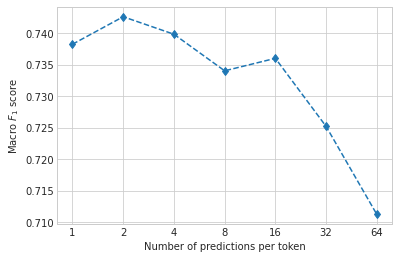

bert-base-uncased by_f_score


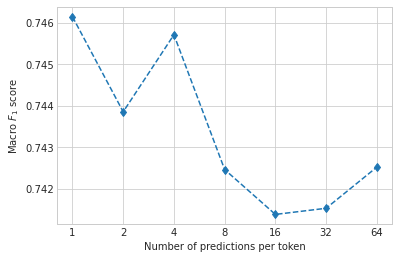

bert-base-cased by_loss


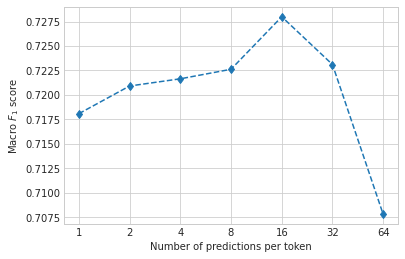

bert-base-cased by_f_score


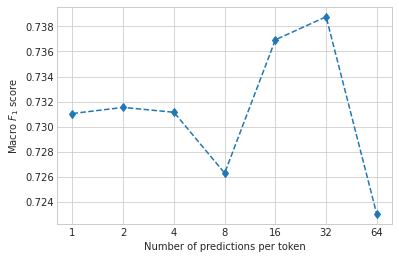

albert-base-v1 by_loss


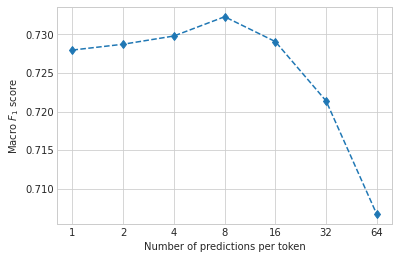

albert-base-v1 by_f_score


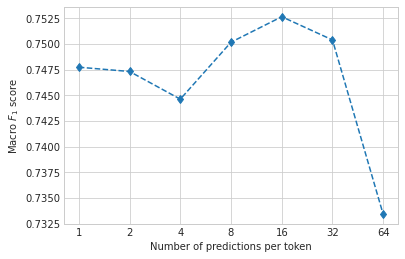

In [14]:
for (model_name, model_type), f_scores in scores.items():
    print(model_name, model_type)
    plt.style.use('seaborn-whitegrid')
    # plt.title('Multiple predictions')
    plt.ylabel('Macro $F_1$ score')
    plt.xlabel('Number of predictions per token')
    plt.xticks(np.arange(int(np.log2(64))+1), [str(2**i) for i in range(0, int(np.log2(64))+1)])
    plt.plot(f_scores[::-1], '--d')
    plt.savefig(f'imgs/valid_multiple_predictions/{model_name}_{model_type}.pdf')
    plt.show()